# Demo of RtDeep

We define a simple network using RtDeep with microcircuits.

Task: mapping a 1-D signal in time onto another 1-D signal.

The model uses real time dynamics with Euler integration, LE, dendritic error propagation and a phased implementation of DTP-DRL.

## Definitions

In [1]:
%matplotlib widget

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=14,family='serif')
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from microcircuit import *
import sys
import pandas as pd


#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport microcircuit

In [2]:
# simulation settings

dt = 0.01 # in ms
tauxi = 10 * dt
Tpres = 100 * dt
Ttot = 100 * Tpres # total simulation time

In [3]:
np.random.seed(1234)

# Init model: weights, voltages

layers = [1, 1, 1]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [0.0] * (len(layers) - 1)
eta_IP = [40.0] * (len(layers) - 1)
eta_PI = [50.0] * (len(layers) - 1)

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 1, size=(layers[i+1], layers[i])))

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))

## Test self-predicting dynamics (no target)

In [4]:
# input rates: random inputs

r0_random = np.random.uniform(0, 1, size=(int(Tpres / dt), layers[0]))
r0_random = np.repeat(r0_random, int(Ttot / Tpres), axis=0)

In [5]:
mc1 = model(dt, tauxi, Tpres, 'FA', logistic, d_logistic, layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

In [30]:
u_time_series = []
uIbreve_time_series = []
uPbreve_time_series = []
rIbreve_time_series = []
rPbreve_time_series = []
vapi_time_series = []

WPP_time_series = []
BPP_time_series = []
WIP_time_series = []
BPI_time_series = []

for i in range(len(r0_random)):
    mc1.evolve_system(r0=r0_random[i])
    
    uIbreve_time_series.append(copy.deepcopy(mc1.uI_breve))
    uPbreve_time_series.append(copy.deepcopy(mc1.uP_breve))
    rIbreve_time_series.append(copy.deepcopy(mc1.rI_breve))
    rPbreve_time_series.append(copy.deepcopy(mc1.rP_breve))
    
    # after every Tpres, save states
    if i % int(Tpres / dt) == 0:
        u_time_series.append(copy.deepcopy(mc1.get_voltages()))

        
        vapi_time_series.append(copy.deepcopy(mc1.vapi))
        WPP, WIP, BPP, BPI = mc1.get_weights()
        WPP_time_series.append(copy.deepcopy(WPP))
        BPP_time_series.append(copy.deepcopy(BPP))
        WIP_time_series.append(copy.deepcopy(WIP))
        BPI_time_series.append(copy.deepcopy(BPI))
        
uP_time_series = [u[0] for u in u_time_series]
uI_time_series = [u[1] for u in u_time_series]

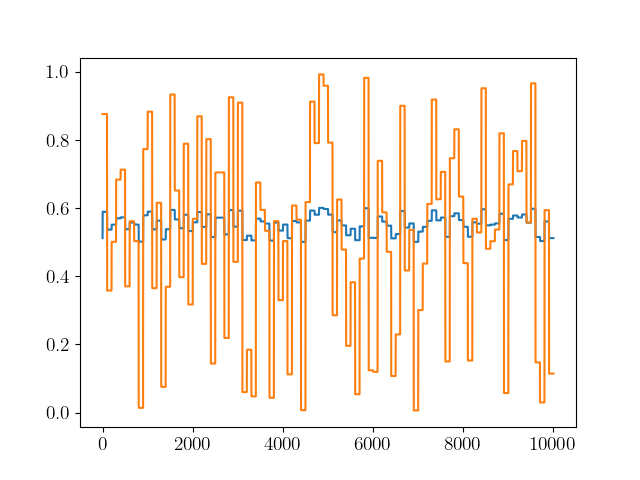

In [31]:
fig = plt.figure()
plt.plot(np.array([rPbreve[0] for rPbreve in rPbreve_time_series]).ravel())
plt.plot(r0_random)
plt.show()

/var/folders/zb/q43ry99x69g19b1w0cyrrr700000gn/T/ipykernel_94707/1758017936.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(len(uP_time_series[0]) + len(uPbreve_time_series[0]) + 1)


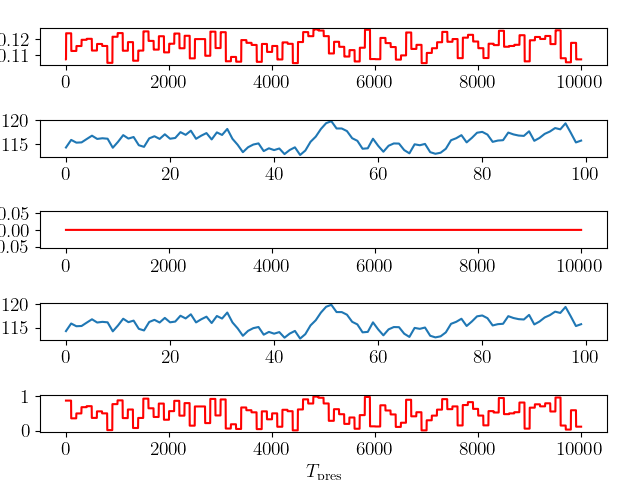

In [32]:
fig, ax = plt.subplots(len(uP_time_series[0]) + len(uPbreve_time_series[0]) + 1)

plt.tight_layout()

ax[len(ax)-1].plot(r0_random, 'r')

for i in range(len(uPbreve_time_series[0])):
    uPbreve = i * np.array([uPbreve[i] for uPbreve in uPbreve_time_series])
    ax[len(ax)-2-2*i-1].plot(uPbreve, 'r')
    
for j in range(len(uP_time_series[0])):
    uP = np.array([uP[i] for uP in uP_time_series])
    ax[len(ax)-2-2*j].plot(uP)

plt.yscale('linear')

label = '$T_{ \mathrm{pres}} $'
plt.xlabel(label)
# plt.legend()

plt.show()

In [9]:
# fig, ax = plt.subplots()
# uIbreve = np.array(uIbreve_time_series).reshape(-1, np.array(uIbreve_time_series).shape[-1])
# uPbreve = np.array([uPb[1] for uPb in uPbreve_time_series]).reshape(-1, np.array(uPbreve_time_series).shape[-1])
# ax.plot(uIbreve, '--')
# ax.plot(uPbreve)
# plt.yscale('linear')
# label = '$T_{ \mathrm{pres}} $'
# plt.xlabel(label)
# # plt.title(f'Layer {len(layers)-1} apical voltages')
# plt.show()

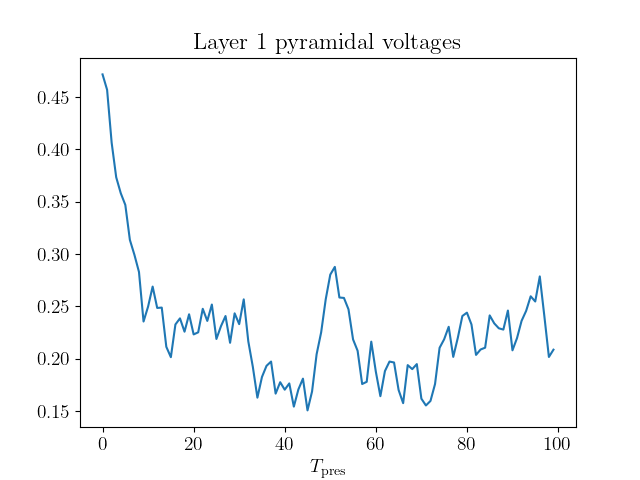

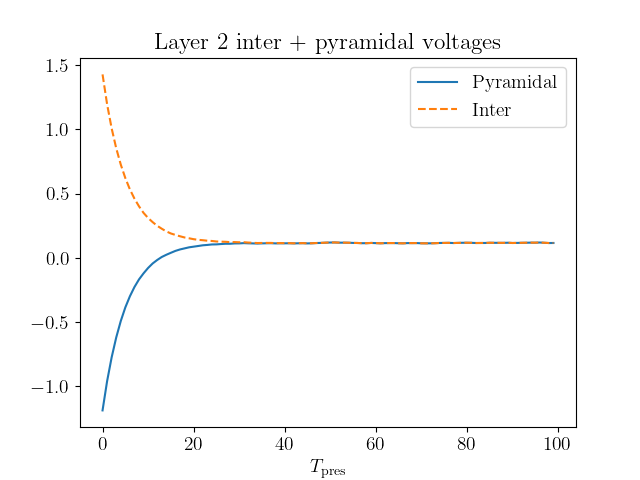

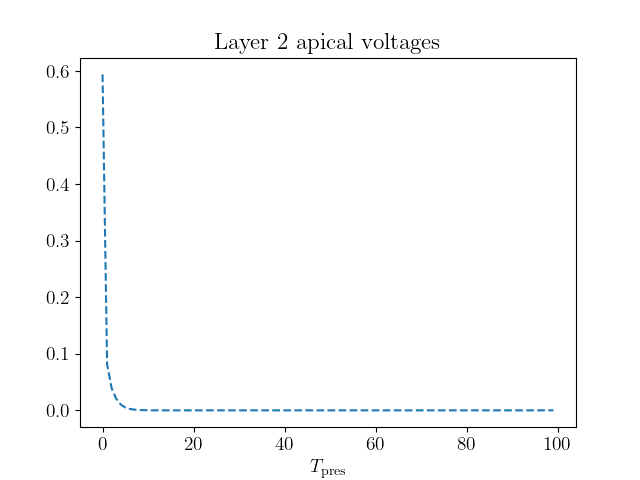

In [9]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    uP = np.array([uP[i] for uP in uP_time_series])
    ax.plot(uP)
    plt.yscale('linear')
    label = '$T_{ \mathrm{pres}} $'
    plt.xlabel(label)
    plt.title(f'Layer {i+1} pyramidal voltages')
    plt.show()

# fig, ax = plt.subplots()
uI = np.array(uI_time_series).reshape(-1, np.array(uI_time_series).shape[-1])
# ax.plot(uI, '--')
# plt.yscale('linear')
# label = '$T_{ \mathrm{pres}} $'
# plt.xlabel(label)
# plt.title(f'Layer {len(layers)-1} interneuron voltages')
# plt.show()

fig, ax = plt.subplots()
uP = np.array([uP[-1] for uP in uP_time_series])
ax.plot(uP, label='Pyramidal')
ax.plot(uI, '--', label='Inter')
plt.yscale('linear')
label = '$T_{ \mathrm{pres}} $'
plt.xlabel(label)
plt.title(f'Layer {len(layers)-1} inter + pyramidal voltages')
plt.legend()
plt.show()


fig, ax = plt.subplots()
vapi = np.array(vapi_time_series).reshape(-1, np.array(uI_time_series).shape[-1])
ax.plot(vapi, '--')
# plt.yscale('log')
label = '$T_{ \mathrm{pres}} $'
plt.xlabel(label)
plt.title(f'Layer {len(layers)-1} apical voltages')
plt.show()

In [10]:
cos_BPI_BPP = []
for i in range(len(BPI_time_series[0])):
    cos_BPI_BPP.append(np.array([
        cos_sim(BPI_time_series[j][i], -BPP_time_series[j][i]) for j in range(len(BPI_time_series))
                           ]))
    
cos_WIP_WPP = []
for i in range(len(WIP_time_series[0])):
    cos_WIP_WPP.append(np.array([
        cos_sim(WIP_time_series[j][i], WPP_time_series[j][i+1]) for j in range(len(WIP_time_series))
                           ]))

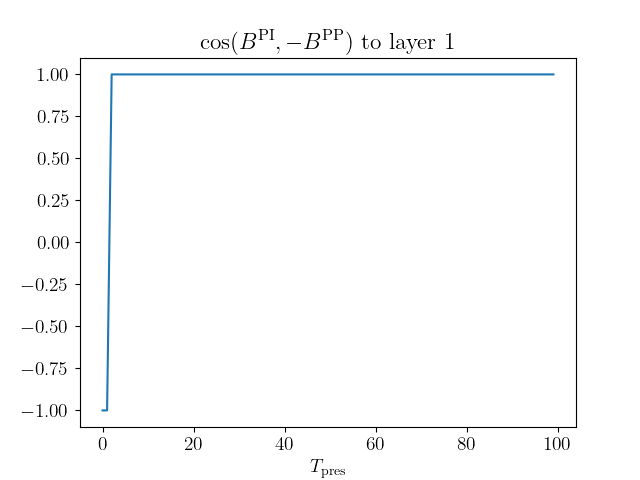

In [11]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_BPI_BPP[i])
    plt.yscale('linear')
    label = '$T_{ \mathrm{pres}} $'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

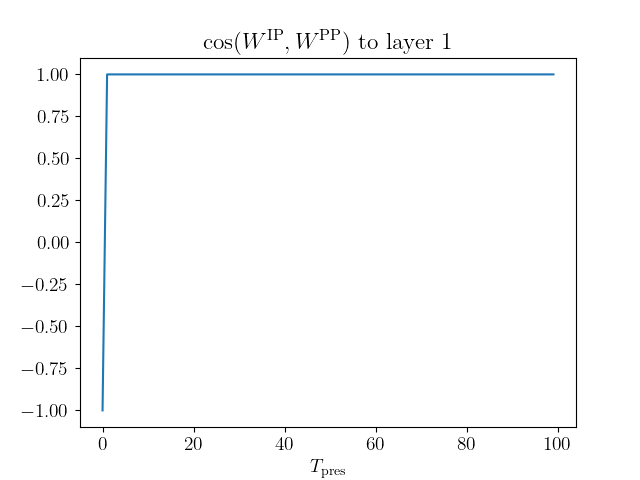

In [12]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WIP_WPP[i])
    plt.yscale('linear')
    label = '$T_{ \mathrm{pres}} $'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

In [13]:
WIP_time_series[0]

[array([[-0.04205974]])]

In [14]:
WIP_time_series[-1]

[array([[0.27240854]])]

In [15]:
WPP_time_series[0][1]

array([[0.27259261]])

In [16]:
BPI_time_series[0][0] + BPP_time_series[0][0]

array([[1.09471394]])

In [17]:
BPI_time_series[-1][0] + BPP_time_series[-1][0]

array([[-0.00039727]])

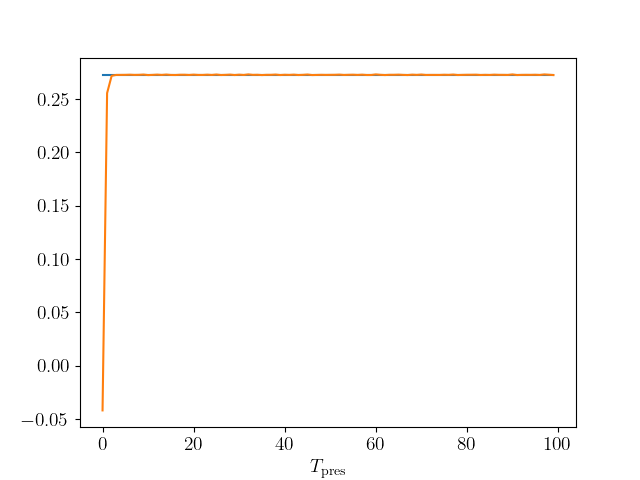

In [18]:

fig, ax = plt.subplots()
ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
ax.plot(np.array(WIP_time_series).ravel())
plt.yscale('linear')
label = '$T_{ \mathrm{pres}} $'
plt.xlabel(label)
# plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
plt.show()

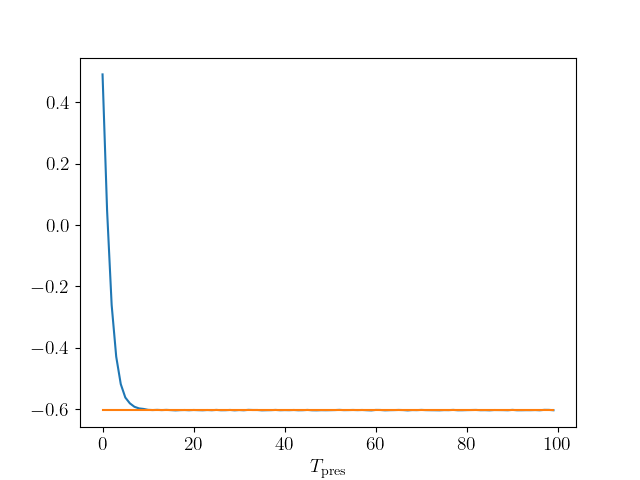

In [19]:

fig, ax = plt.subplots()
ax.plot(np.array(BPI_time_series).ravel())
ax.plot(-np.array(BPP_time_series).ravel())
plt.yscale('linear')
label = '$T_{ \mathrm{pres}} $'
plt.xlabel(label)
# plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
plt.show()